# 준비
## 라이브러리

In [1]:
import datetime, os, time, pathlib
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from tensorflow.keras import losses, models, layers, optimizers, callbacks, utils, metrics
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import EfficientNetV2S
import matplotlib.pyplot as plt

tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 데이터

In [2]:
# Dataframe
train = pd.read_csv("D:Dataset/dataset/Task1/info_etri20_emotion_train.csv", index_col=0)
train["Daily"] = train["Daily"].astype("str")
train["Gender"] = train["Gender"].astype("str")
train["Embellishment"] = train["Embellishment"].astype("str")

# Helper function

In [3]:
def get_label(target):
    one_hot = target == class_names  # True / False
    return tf.argmax(one_hot)


def process_path(file_path, target):  # image, label
    label = get_label(target)  # 원-핫 벡터 label     |       4 -> (0,0,0,0,1,0,0)
    img = tf.io.read_file(file_path)  # %A3 %df %Ae #16진법 2비트
    img = tf.io.decode_jpeg(img, channels=3)  # 2진법 8비트로 해독 (0~255)
    img = tf.image.resize(img, [img_height, img_width])  # 사이즈 조절 (3 채널만 가능하다)
    img = img / 255  # normalize ([0.444, 0.234, 0.323]) # 정규화 1/255
    return img, label

def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds


def batch_calc(size):
    if size >= 400:
        batch_size = 1
    elif size >= 300:
        batch_size = 4
    elif size >= 200:
        batch_size = 8
    else:
        batch_size = 16
    return batch_size


def build_eff_model(cl):
    # Top
    x = layers.Input(shape=(img_height, img_width, 3))  #input_layer
    y = base_model(x)  # EfficientB7 , inclode_top = False, inclode_top=True면 input_layer를 포함함

    # Rebuild
    y = layers.GlobalAveragePooling2D(name="avg_pool")(y)
    y = layers.BatchNormalization()(y)
    y = layers.Dense(128,
                     activation=tf.keras.layers.LeakyReLU(),
                     name="Dense_last")(y)
    y = layers.BatchNormalization()(y)
    y = layers.Dense(cl, activation="softmax", name="Pred")(y)
    # 클래스 개수만큼 마지막 Dense 층 설정, (0/1 분류면 Dense=1, sigmoid), (다중 분류면 Dense=N, softmax)

    # compile
    model = models.Model(x, y, name="EfficientNet")
    optimizer = optimizers.Adam(learning_rate=0.0002)
    loss = losses.SparseCategoricalCrossentropy(
    )  # label이 원-핫이면 SCC, # label이 원-핫이 아니면 CC
    model.compile(optimizer=optimizer, loss=loss, metrics=["acc"])
    return model


simple_aug = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
        layers.RandomBrightness(0.2),
        layers.RandomContrast(0.2)
    ]
)

In [4]:
from IPython.display import clear_output
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

class PlotLearning(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []   
    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]     
        metrics = [x for x in logs if 'val' not in x]
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)
        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)      
            axs[i].legend()
        plt.tight_layout()
        plt.show()

# Training

## Gender

In [ ]:
# DS
list_ds = tf.data.Dataset.from_tensor_slices( (train["data_path"].values, train["Gender"].values) ) # (x,y) = (image, label)
list_ds = list_ds.shuffle(len(list_ds), reshuffle_each_iteration=False) # 데이터 셔플 / 랜덤
class_names = np.array( train["Gender"].unique() )

# DS split (10%)
val_size = int(len(list_ds)*0.1) # 1147 # 10%는 valid set
train_ = list_ds.skip(val_size) # 10% 를 넘김 # 90%
valid_ = list_ds.take(val_size) # 10% 를 가짐 
NUM_TRAIN = tf.data.experimental.cardinality(train_).numpy()
NUM_VALID = tf.data.experimental.cardinality(valid_).numpy()

In [ ]:
# batch_size = 16
# AUTOTUNE = tf.data.experimental.AUTOTUNE
# NAME = ["B4","B7"]
# MODEL = [EfficientNetB4, EfficientNetB7]
# SIZE = [180, 300]
# for name, M, size in zip(NAME, MODEL, SIZE):
#     # img 사이즈 설정
#     img_height = size
#     img_width = size
#     image_size=(img_height, img_width)
    
#     batch_size=batch_calc(size)
    
#     # 데이터셋 호출!
#     # img_path, label -> img, one_hot vector label
#     train_ds = train_.map(process_path, num_parallel_calls=AUTOTUNE)
#     valid_ds = valid_.map(process_path, num_parallel_calls=AUTOTUNE)
    
#     # 하드웨어 성능향상 
#     train_ds = configure_for_performance(train_ds)
#     valid_ds = configure_for_performance(valid_ds)
    
#     # 베이스 모델 호출!
#     base_model = M(input_shape=(img_height,img_width,3), include_top=False, weights='imagenet')
#     model = build_eff_model()
    
#     # 콜백!
#     ckp = callbacks.ModelCheckpoint(f"model/model_{name}_gender.h5", save_best_only=True,  monitor="val_acc")
#     lr = callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5, cooldown=2)
#     es = callbacks.EarlyStopping(monitor="val_loss", patience=10)
    
#     # 학습!
#     print("\n\n"+name+"Pre Training")
#     base_model.trainable=False
#     model.fit(train_ds, epochs=20, validation_data=valid_ds, callbacks=[ckp, lr,es])
#     print("\n\n"+name+"Fine Tuning")
#     base_model.trainable=True
#     model.fit(train_ds, epochs=20, validation_data=valid_ds, callbacks=[ckp, lr,es])

## Daily

In [ ]:
# # DS
# list_ds = tf.data.Dataset.from_tensor_slices( (train["data_path"].values, train["Daily"].values) ) # (x,y) = (image, label)
# list_ds = list_ds.shuffle(len(list_ds), reshuffle_each_iteration=False) # 데이터 셔플 / 랜덤
# class_names = np.array(train["Daily"].unique())
# class_len = len(class_names)

# # DS split (10%)
# val_size = int(len(list_ds)*0.1) # 1147 # 10%는 valid set
# train_ = list_ds.skip(val_size) # 10% 를 넘김 # 90%
# valid_ = list_ds.take(val_size) # 10% 를 가짐 
# NUM_TRAIN = tf.data.experimental.cardinality(train_).numpy()
# NUM_VALID = tf.data.experimental.cardinality(valid_).numpy()

In [ ]:
# batch_size = 16
# AUTOTUNE = tf.data.experimental.AUTOTUNE
# NAME = ["B4","B5"]
# MODEL = [EfficientNetB4, EfficientNetB5]
# SIZE = [180, 240]
# for name, M, size in zip(NAME, MODEL, SIZE):
#     # img 사이즈 설정
#     img_height = size
#     img_width = size
#     image_size=(img_height, img_width)
    
#     batch_size=batch_calc(size)
    
#     # 데이터셋 호출!
#     # img_path, label -> img, one_hot vector label
#     train_ds = train_.map(process_path, num_parallel_calls=AUTOTUNE)
#     valid_ds = valid_.map(process_path, num_parallel_calls=AUTOTUNE)
    
#     # 하드웨어 성능향상 
#     train_ds = configure_for_performance(train_ds)
#     valid_ds = configure_for_performance(valid_ds)
    
#     # 베이스 모델 호출!
#     base_model = M(input_shape=(img_height,img_width,3), include_top=False, weights='imagenet')
#     model = build_eff_model(class_len)
    
#     # 콜백!
#     ckp_p = callbacks.ModelCheckpoint(f"model/model_{name}_Daily_P.h5", save_best_only=True,  monitor="val_acc")
#     ckp_t = callbacks.ModelCheckpoint(f"model/model_{name}_Daily_T.h5", save_best_only=True,  monitor="val_acc")
#     lr = callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5, cooldown=2)
#     es = callbacks.EarlyStopping(monitor="val_loss", patience=10)
    
#     # 학습!
#     print("\n"+"--------------    Pre Training       -----------------")
#     print("----------------------- "+name+" ------------------------")
#     base_model.trainable=False
#     model.fit(train_ds, epochs=20, validation_data=valid_ds, callbacks=[ckp, lr,es])
#     print("\n"+"--------------      Fine Tuning     -----------------")
#     print("----------------------- "+name+" -----------------------")
#     base_model.trainable=True
#     model.fit(train_ds, epochs=20, validation_data=valid_ds, callbacks=[ckp, lr,es])

## Embellishment

In [5]:
# DS
list_ds = tf.data.Dataset.from_tensor_slices( (train["data_path"].values, train["Embellishment"].values) ) # (x,y) = (image, label)
list_ds = list_ds.shuffle(len(list_ds), reshuffle_each_iteration=False) # 데이터 셔플 / 랜덤
class_names = np.array(train["Embellishment"].unique())
class_len = len(class_names)

# DS split (10%)
val_size = int(len(list_ds)*0.1) # 1147 # 10%는 valid set
train_ = list_ds.skip(val_size) # 10% 를 넘김 # 90%
valid_ = list_ds.take(val_size) # 10% 를 가짐 
NUM_TRAIN = tf.data.experimental.cardinality(train_).numpy()
NUM_VALID = tf.data.experimental.cardinality(valid_).numpy()

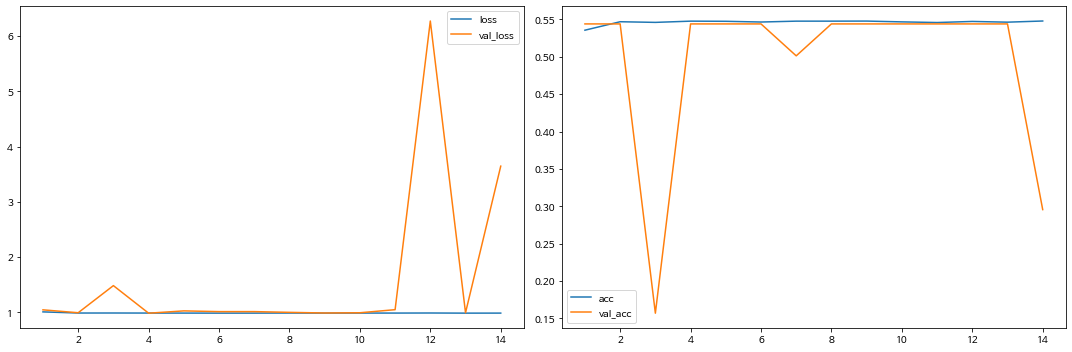

5165/5165 [==============================] - 525s 102ms/step - loss: 0.9861 - acc: 0.5479 - val_loss: 3.6460 - val_acc: 0.2956


In [6]:
batch_size = 2
AUTOTUNE = tf.data.experimental.AUTOTUNE
NAME = ["V2S"]
MODEL = [EfficientNetV2S]
SIZE = [384]
for name, M, size in zip(NAME, MODEL, SIZE):
    # img 사이즈 설정
    img_height = size
    img_width = size
    image_size=(img_height, img_width)
    
#     batch_size=batch_calc(size)
    
    # 데이터셋 호출!
    # img_path, label -> img, one_hot vector label
    train_ds = train_.map(process_path, num_parallel_calls=AUTOTUNE)
    valid_ds = valid_.map(process_path, num_parallel_calls=AUTOTUNE)
    
    # 증강
    train_ds = train_ds.map(lambda x, y: (album_aug(x), y), num_parallel_calls=AUTOTUNE)
    
    # 하드웨어 성능향상 
    train_ds = configure_for_performance(train_ds) 
    valid_ds = configure_for_performance(valid_ds)
    
    # 베이스 모델 호출!
    base_model = M(input_shape=(img_height,img_width,3), include_top=False, weights='imagenet')
    model = build_eff_model(class_len)
    
    # 콜백!
    ckp = callbacks.ModelCheckpoint(f"model/model_{name}_Embellishment.h5", save_best_only=True,  monitor="val_acc")
    es = callbacks.EarlyStopping(monitor="val_loss", patience=10)
    
    # 학습!
    print("\n"+"--------------      Fine Tuning     -----------------")
    print("----------------------- "+name+" -----------------------")
    model.fit(train_ds, epochs=30, validation_data=valid_ds, callbacks=[ckp, PlotLearning(), es])